<a href="https://colab.research.google.com/github/calladogt/Research-internship/blob/master/Simulators/ks-simulator/KS-modelFF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prediction of the KS system: a model using Feed-Forward Neural Network

 In this notebook, I will use a simple model of Deep Learning to predict the KS system. More precisely, we wanna predict the next step of a given state of the system. To do it, a simple feed-forward neural network will be used.
It is just the first model trained to predict the system. I will try many configurations and varieties.

To generate the data, I will use the KS.py code provided by Alessandro Bucci.

In [1]:
import numpy as np
import torch as th
import time
from scipy import stats
#from KS import KS
import matplotlib.pyplot as plt
from sklearn import preprocessing

## Some functions: 

In [2]:
def drawKS(U_sim, x_axis, t_axis ,startT=0,endT=0, width = 10, divwidth = 4): 
    """
    This function will plot the evolution of the KS system (U_sim) over time (t_axis)
    
    """
    fig = plt.figure(figsize=(width, width/divwidth))
    ax = fig.gca()
    ola = ax.contourf((t_axis[startT:endT])/20.83, x_axis, U_sim[startT:endT,:].T, 15)
    cbar = plt.colorbar(ola)
    plt.xlabel('Lyapunov Times')
    plt.ylabel('X')
    plt.show()

In [3]:
def prediction(model,start_position,N_step_pred,state_history_norm_th):
    """
    This function will simulate the model for a given start_position of 
    state_history_norm_th from start_position to start_position+N_step_pred
    and compares this simulation with the true value given by state_history_norm_th
    
    input:
    - model: the model that will be used to make the prediction
    - start_position: the position in the vector state_history_norm_th that will start the simulation
    - N_step_pred: number of the steps to simulate
    - state_history_norm_th: the true simulation given by KS.py. it will be used as the start point
      to initiate our model simulation and to verify the quality of this simulation
    
    
    output:
    - print: the true spatiotemporal evolution of KS system
             our simulation by the model
             the difference between them per step of the simulation
    
    state_history: all the spatialtemporal evolution of the system. shape: [number of iteractions,samples_points]
    time_counter: array of the time corresponding to each interaction
    position_x: array of samples_points points that goes from 0 to length
    """
    
    y_true=state_history_norm_th[start_position:start_position+N_step_pred,:]
    sample_points=state_history_norm_th.size(1)
    current_state = state_history_norm_th[start_position,:]
    prediction_model = th.zeros((N_step_pred, sample_points))


    for i in range(N_step_pred):
        current_state=model(current_state)
        prediction_model[i,:]=current_state


    prediction_model_np = prediction_model.detach().numpy()
    y_true_np = y_true.cpu().numpy()
    dif=np.mean(np.absolute(prediction_model_np-y_true_np),axis=1)

    print('The true solution:')
    drawKS(y_true_np, position_x, time_counter,startT=1,endT=N_step_pred, width = 10, divwidth = 4) 
    print('The model solution:')
    drawKS(prediction_model_np, position_x,time_counter,startT=1,endT=N_step_pred, width = 10, divwidth = 4)
    print('The difference between them:')
    drawKS(np.absolute(y_true_np-prediction_model_np), position_x,time_counter,startT=1,endT=N_step_pred, width = 10, divwidth = 4)

    plt.figure(figsize = (8, 3))
    plt.plot(np.arange(N_step_pred)*0.25/20.83, np.absolute(dif))
    plt.title('Difference between prediction and true value')
    plt.ylabel('MAE')
    plt.xlabel('Lyapunov Times')

## Loading and normalizing the data
First, let's set the parameters of the simulation. Pay attention to set the correct parameters to the data set loaded.

In [ ]:
final_time = 2500 # the total time of the simulation
dt = 0.25 # the time step 
length = 22 # the "physical" length of the domaine. pay attention cuz this value will determine if the system is regular or chaotic
sample_points = 64 # the number of sample points on this length. It will be the size of the input in our system

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
cd ../content/drive/My Drive/Colab Notebooks/

/content/drive/My Drive/Colab Notebooks


In [ ]:
#to load data
from numpy import load

number_of_sets = 50

state_history = np.loadtxt('state_history_5_trainingtotal.dat')
time_counter = np.linspace(0,2000*number_of_sets,8001*number_of_sets)
position_x = np.loadtxt('position_5_0.dat')

In [ ]:
state_history.shape

(400050, 64)

Let's normalize the data to be between [-0.975,0.975]. It will allow us to use other activation fonction (like Tanh):

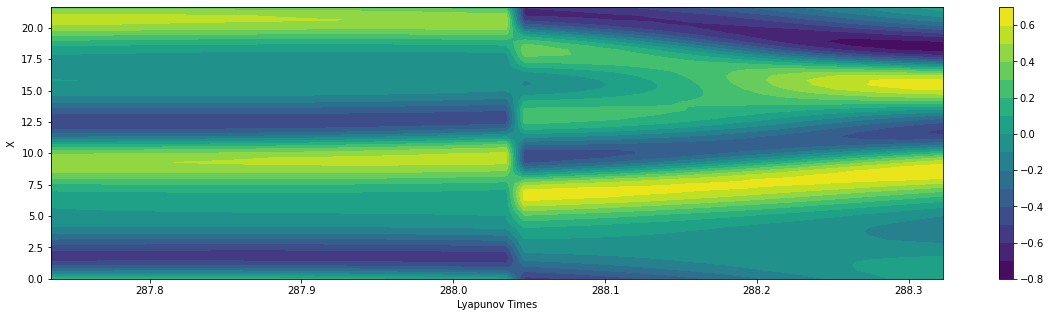

In [ ]:
min_max_scaler = preprocessing.MinMaxScaler(feature_range=(-0.975,0.975))
state_history_norm = min_max_scaler.fit_transform(state_history)

#visualizing the solution of KS equation
drawKS(state_history_norm, position_x, time_counter,7975+8001*2,8025+8001*2,20,4)

# Separating the data into training and test sets:

In [ ]:
to_ignore = 1

X = state_history_norm[:-1,:] #our input: all the data excluding the last one
Y = state_history_norm[1:,:] #our output: all the data minus the first one

NN = state_history_norm.shape[0]-1-number_of_sets*to_ignore
Nt = int(NN*0.9) # number of training
Nv = int(NN*0.1) # number of validation


np.random.seed(0)

seq1 = np.arange(8001)
seq1 = seq1[to_ignore:8001-to_ignore]
tam = seq1.shape
seq = np.zeros((tam[0]*number_of_sets))
for i in range(number_of_sets):
  seq[tam[0]*i:tam[0]*(i+1)] = (seq1+8001*i)

seq = seq.astype(np.integer)

np.random.shuffle(seq)
train_seq=seq[0:Nt]
valid_seq=seq[-Nv:]
X_train = X[train_seq]
Y_train = Y[train_seq]
X_valid = X[valid_seq]
Y_valid = Y[valid_seq]
#converting to tensor
X_train_th = th.from_numpy(X_train).cuda()
Y_train_th = th.from_numpy(Y_train).cuda()
X_valid_th = th.from_numpy(X_valid).cuda()
Y_valid_th = th.from_numpy(Y_valid).cuda()

In [ ]:
#just to use it later:
state_history_norm_th = th.from_numpy(state_history_norm).cuda()

# Training

In [ ]:
def train(model,X_train,X_valid,Y_train,Y_valid,epochs=30,batch_size=64):
    Nt=len(X_train)
    Nv=len(X_valid)
    ### Mini-batching and shuffle
    idx = np.arange(Nt)
    nbatch = int(Nt/batch_size)
    train_losses,valid_losses=[],[]
    start_time=time.time()
    print("Epoch\tTrain Loss\tValid Loss")
    
    #Just to see the prediction of our random parameters
    model.eval()
    with th.no_grad():
        running_loss=0
        for bi in range(nbatch):
            ids = idx[bi*batch_size:(bi+1)*batch_size]
            x = X_train[ids]
            ttf_calc=model(x).squeeze()
            ttf = Y_train[ids]
            loss=loss_fn(ttf_calc,ttf)
            running_loss+=loss.item()
        train_losses.append(running_loss/nbatch)
        running_loss=0
        ttf_calc=model(X_valid).squeeze()
        ttf = Y_valid
        loss=loss_fn(ttf_calc,ttf)
        running_loss+=loss.item()
        valid_losses.append(running_loss)
        #it will print the result in epoch=0 during the training
    
    #starting the training here:
    for e in range(epochs):
        model.train()
        print("{}\t".format(e),"{:.5f}..\t".format(train_losses[-1]),"{:.5f}..".format(valid_losses[-1]))  
        np.random.shuffle(idx)
        running_loss=0
        for bi in range(nbatch):
            ids = idx[bi*batch_size:(bi+1)*batch_size]
            x = X_train[ids]
            optimizer.zero_grad()
            ttf_calc=model(x).squeeze()
            ttf = Y_train[ids]
            loss=loss_fn(ttf_calc,ttf)
            loss.backward()
            optimizer.step()
            running_loss+=loss.item()
            
        # training is over for one epoch
        #now evaluate the model with the valid set:
        model.eval()
        accuracy=0
        train_losses.append(running_loss/nbatch)
        running_loss=0
        with th.no_grad():
            x = X_valid
            ttf_calc=model(x).squeeze()
            ttf = Y_valid
            loss=loss_fn(ttf_calc,ttf)
            running_loss+=loss.item()
            valid_losses.append(running_loss)
    print("{}\t".format(e+1),"{:.7f}..\t".format(train_losses[-1]),"{:.7f}..".format(valid_losses[-1]))     
    print("---------- Best : {:.7f}".format(min(valid_losses)), " at epoch " 
          , np.fromiter(valid_losses, dtype=np.float).argmin(), " / ",epochs )
    print('Execution time={:.2f}s'.format(time.time()-start_time))
    #plot some graphs
    plt.figure(figsize = (9, 1.5))
    ax= plt.subplot(1, 2, 1)
    plt.plot(train_losses)
    ax.set_ylim(bottom=0)
    ax= plt.subplot(1, 2, 2)
    plt.plot(valid_losses)
    ax.set_ylim(bottom=0)
    return train_losses, valid_losses

# Model 1

In [ ]:
n_input=64
n_output=64
n_hidden=128
model = th.nn.Sequential(
    th.nn.Linear(n_input,n_hidden),
    th.nn.LeakyReLU(),
    th.nn.Linear(n_hidden,n_output),
    th.nn.Tanh()
)
model.double()
model.cuda()
optimizer=th.optim.Adam(model.parameters(),lr=1e-5)
loss_fn=th.nn.MSELoss()

Epoch	Train Loss	Valid Loss
0	 0.14927..	 0.14930..
1	 0.05054..	 0.00984..
2	 0.00448..	 0.00179..
3	 0.00123..	 0.00093..
4	 0.00079..	 0.00069..
5	 0.00063..	 0.00057..
6	 0.00054..	 0.00050..
7	 0.00048..	 0.00046..
8	 0.00044..	 0.00042..
9	 0.00041..	 0.00039..
10	 0.00038..	 0.00037..
11	 0.00036..	 0.00035..
12	 0.00034..	 0.00033..
13	 0.00033..	 0.00032..
14	 0.00031..	 0.00031..
15	 0.00030..	 0.00030..
16	 0.00029..	 0.00029..
17	 0.00028..	 0.00028..
18	 0.00027..	 0.00027..
19	 0.00027..	 0.00026..
20	 0.00026..	 0.00026..
21	 0.00025..	 0.00025..
22	 0.00025..	 0.00025..
23	 0.00024..	 0.00024..
24	 0.00024..	 0.00024..
25	 0.00023..	 0.00023..
26	 0.00023..	 0.00023..
27	 0.00022..	 0.00022..
28	 0.00022..	 0.00022..
29	 0.00022..	 0.00021..
30	 0.00021..	 0.00021..
31	 0.00021..	 0.00021..
32	 0.00021..	 0.00020..
33	 0.00020..	 0.00020..
34	 0.00020..	 0.00020..
35	 0.00020..	 0.00020..
36	 0.00019..	 0.00019..
37	 0.00019..	 0.00019..
38	 0.00019..	 0.00019..
39	 0.0

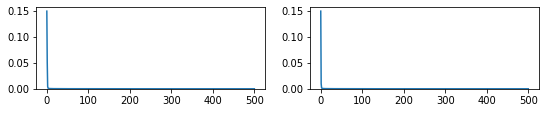

In [ ]:
epochs_counter=500
batch_size=64
train_losses, valid_losses = train(model,X_train_th,X_valid_th,Y_train_th,Y_valid_th,epochs=epochs_counter,batch_size=batch_size)

In [ ]:
#TO SAVE THE MODEL

tosave_data = {'model': model,
               'epoch': epochs_counter,
               'batch_size': batch_size,
               'model_state_dict': model.state_dict(),
               'optimizer_state_dict': optimizer.state_dict(),
               'loss': loss_fn,
               'training loss': train_losses,
               'valid loss': valid_losses,}
# Write a pickle file using pytorch 
th.save(tosave_data, "modelff1")

Results for the model 1:

The true solution:


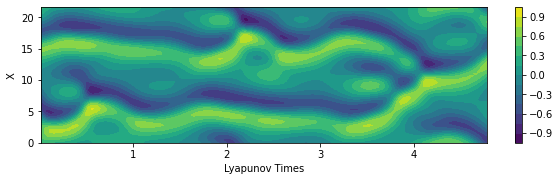

The model solution:


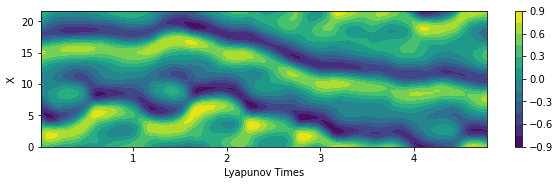

The difference between them:


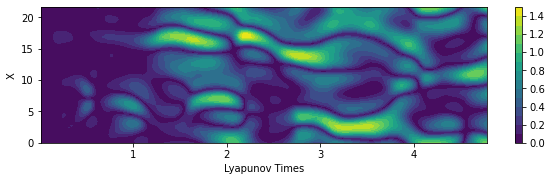

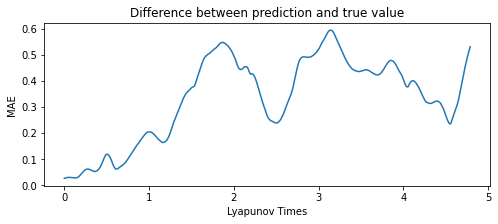

In [ ]:
start_position=10000
N_step_pred=400
prediction(model,start_position,N_step_pred,state_history_norm_th)

# Model 2

In [ ]:
n_input=64
n_output=64
n_hidden=128
model = th.nn.Sequential(
    th.nn.Linear(n_input,n_hidden),
    th.nn.LeakyReLU(),
    th.nn.Linear(n_hidden,n_hidden),
    th.nn.LeakyReLU(),
    th.nn.Linear(n_hidden,n_output),
    th.nn.Tanh()
)
model.double()
model.cuda()
optimizer=th.optim.Adam(model.parameters(),lr=1e-5)
loss_fn=th.nn.MSELoss()

Epoch	Train Loss	Valid Loss
0	 0.14550..	 0.14544..
1	 0.04382..	 0.00600..
2	 0.00225..	 0.00095..
3	 0.00073..	 0.00060..
4	 0.00053..	 0.00048..
5	 0.00045..	 0.00042..
6	 0.00040..	 0.00038..
7	 0.00036..	 0.00035..
8	 0.00034..	 0.00033..
9	 0.00032..	 0.00031..
10	 0.00030..	 0.00029..
11	 0.00029..	 0.00028..
12	 0.00028..	 0.00027..
13	 0.00027..	 0.00026..
14	 0.00026..	 0.00025..
15	 0.00025..	 0.00024..
16	 0.00024..	 0.00024..
17	 0.00023..	 0.00023..
18	 0.00023..	 0.00022..
19	 0.00022..	 0.00022..
20	 0.00021..	 0.00021..
21	 0.00021..	 0.00021..
22	 0.00020..	 0.00020..
23	 0.00020..	 0.00020..
24	 0.00020..	 0.00019..
25	 0.00019..	 0.00019..
26	 0.00019..	 0.00019..
27	 0.00018..	 0.00018..
28	 0.00018..	 0.00018..
29	 0.00018..	 0.00018..
30	 0.00017..	 0.00017..
31	 0.00017..	 0.00017..
32	 0.00017..	 0.00017..
33	 0.00017..	 0.00016..
34	 0.00016..	 0.00016..
35	 0.00016..	 0.00016..
36	 0.00016..	 0.00016..
37	 0.00016..	 0.00016..
38	 0.00015..	 0.00015..
39	 0.0

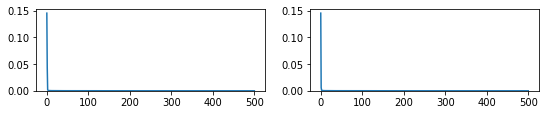

In [ ]:
epochs_counter=500
batch_size=64
train_losses, valid_losses = train(model,X_train_th,X_valid_th,Y_train_th,Y_valid_th,epochs=epochs_counter,batch_size=batch_size)

In [ ]:
#TO SAVE THE MODEL

tosave_data = {'model': model,
               'epoch': epochs_counter,
               'batch_size': batch_size,
               'model_state_dict': model.state_dict(),
               'optimizer_state_dict': optimizer.state_dict(),
               'loss': loss_fn,
               'training loss': train_losses,
               'valid loss': valid_losses,}
# Write a pickle file using pytorch 
th.save(tosave_data, "modelff2")

The true solution:


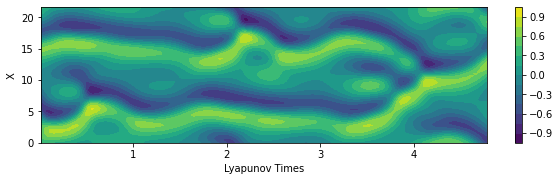

The model solution:


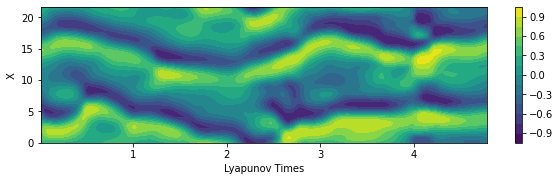

The difference between them:


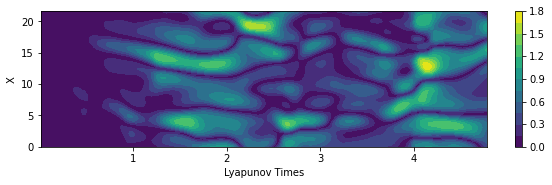

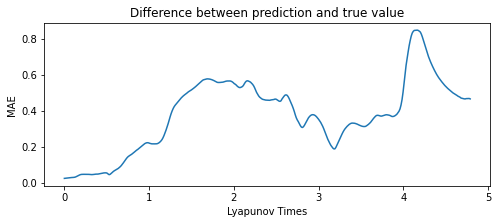

In [ ]:
start_position=10000
N_step_pred=400
prediction(model,start_position,N_step_pred,state_history_norm_th)

# Model 3

In [ ]:
n_input=64
n_output=64
n_hidden=128
model = th.nn.Sequential(
    th.nn.Linear(n_input,n_hidden),
    th.nn.LeakyReLU(),
    th.nn.Linear(n_hidden,n_hidden*2),
    th.nn.LeakyReLU(),
    th.nn.Linear(n_hidden*2,n_hidden),
    th.nn.LeakyReLU(),
    th.nn.Linear(n_hidden,n_output),
    th.nn.Tanh()
)
model.double()
model.cuda()
optimizer=th.optim.Adam(model.parameters(),lr=1e-5)
loss_fn=th.nn.MSELoss()

Epoch	Train Loss	Valid Loss
0	 0.14327..	 0.14325..
1	 0.03215..	 0.00214..
2	 0.00100..	 0.00060..
3	 0.00051..	 0.00044..
4	 0.00040..	 0.00037..
5	 0.00035..	 0.00033..
6	 0.00032..	 0.00030..
7	 0.00029..	 0.00029..
8	 0.00028..	 0.00027..
9	 0.00026..	 0.00025..
10	 0.00025..	 0.00024..
11	 0.00024..	 0.00023..
12	 0.00023..	 0.00022..
13	 0.00022..	 0.00021..
14	 0.00021..	 0.00020..
15	 0.00020..	 0.00020..
16	 0.00019..	 0.00019..
17	 0.00018..	 0.00018..
18	 0.00018..	 0.00018..
19	 0.00017..	 0.00017..
20	 0.00017..	 0.00016..
21	 0.00016..	 0.00016..
22	 0.00016..	 0.00016..
23	 0.00015..	 0.00015..
24	 0.00015..	 0.00015..
25	 0.00014..	 0.00014..
26	 0.00014..	 0.00014..
27	 0.00014..	 0.00014..
28	 0.00013..	 0.00013..
29	 0.00013..	 0.00013..
30	 0.00013..	 0.00013..
31	 0.00012..	 0.00012..
32	 0.00012..	 0.00012..
33	 0.00012..	 0.00012..
34	 0.00012..	 0.00012..
35	 0.00011..	 0.00011..
36	 0.00011..	 0.00011..
37	 0.00011..	 0.00011..
38	 0.00011..	 0.00011..
39	 0.0

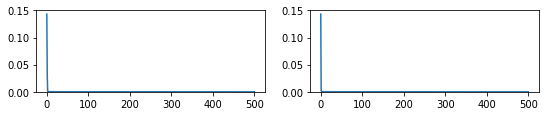

In [ ]:
epochs_counter=500
batch_size=64
train_losses, valid_losses = train(model,X_train_th,X_valid_th,Y_train_th,Y_valid_th,epochs=epochs_counter,batch_size=batch_size)

In [ ]:
#TO SAVE THE MODEL

tosave_data = {'model': model,
               'epoch': epochs_counter,
               'batch_size': batch_size,
               'model_state_dict': model.state_dict(),
               'optimizer_state_dict': optimizer.state_dict(),
               'loss': loss_fn,
               'training loss': train_losses,
               'valid loss': valid_losses,}
               
# Write a pickle file using pytorch 

th.save(tosave_data, "modelff3")

The true solution:


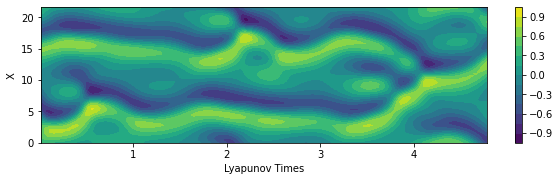

The model solution:


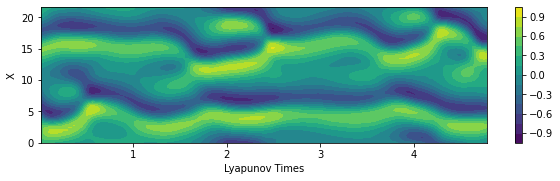

The difference between them:


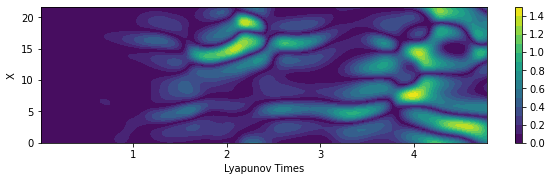

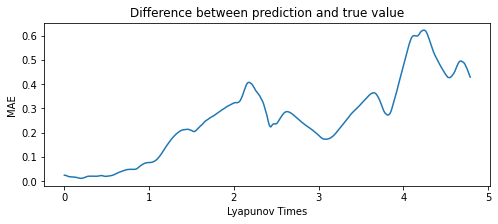

In [ ]:
start_position=10000
N_step_pred=400
prediction(model,start_position,N_step_pred,state_history_norm_th)

Sequential(
  (0): Linear(in_features=64, out_features=128, bias=True)
  (1): LeakyReLU(negative_slope=0.01)
  (2): Linear(in_features=128, out_features=256, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=256, out_features=128, bias=True)
  (5): LeakyReLU(negative_slope=0.01)
  (6): Linear(in_features=128, out_features=64, bias=True)
  (7): Tanh()
)
Model's state_dict:
0.weight 	 torch.Size([128, 64])
0.bias 	 torch.Size([128])
2.weight 	 torch.Size([256, 128])
2.bias 	 torch.Size([256])
4.weight 	 torch.Size([128, 256])
4.bias 	 torch.Size([128])
6.weight 	 torch.Size([64, 128])
6.bias 	 torch.Size([64])
epoch: 500
batch_size: 64
loss: MSELoss()


(0.0, 0.1504152437323941)

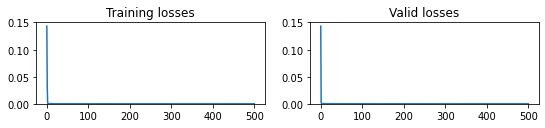

In [ ]:
# Load the pickle file to read the dictionnary from the file
checkpoint = th.load("modelff3")

# restore the model and optimizer states: 
model = checkpoint['model']
model.load_state_dict(checkpoint['model_state_dict'])
epoch = checkpoint['epoch']
batch_size = checkpoint['batch_size']
loss_fn=checkpoint['loss']
train_losses=checkpoint['training loss']
valid_losses=checkpoint['valid loss']


# Print model's state_dict
print(model)
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())
print("epoch:", epoch)
print("batch_size:", batch_size)
print("loss:", loss_fn)
    
# Print optimizer's state_dict
#print("Optimizer's state_dict:")
#for var_name in optimizer.state_dict():
#    print(var_name, "\t", optimizer.state_dict()[var_name])

#plot some graphs
plt.figure(figsize = (9, 1.5))
ax= plt.subplot(1, 2, 1)
plt.plot(train_losses)
plt.title('Training losses')
ax.set_ylim(bottom=0)
ax= plt.subplot(1, 2, 2)
plt.plot(valid_losses)
plt.title('Valid losses')
ax.set_ylim(bottom=0)

## Model 4

In [ ]:
n_input=64
n_output=64
n_hidden=128
model = th.nn.Sequential(
    th.nn.Linear(n_input,n_hidden),
    th.nn.LeakyReLU(),
    th.nn.Linear(n_hidden,n_hidden*2),
    th.nn.LeakyReLU(),
    th.nn.Linear(n_hidden*2,n_hidden*3),
    th.nn.LeakyReLU(),
    th.nn.Linear(n_hidden*3,n_hidden*2),
    th.nn.LeakyReLU(),
    th.nn.Linear(n_hidden*2,n_hidden),
    th.nn.LeakyReLU(),
    th.nn.Linear(n_hidden,n_output),
    th.nn.Tanh()
)
model.double()
model.cuda()
optimizer=th.optim.Adam(model.parameters(),lr=1e-5)
loss_fn=th.nn.MSELoss()

Epoch	Train Loss	Valid Loss
0	 0.14400..	 0.14415..
1	 0.02608..	 0.00188..
2	 0.00099..	 0.00060..
3	 0.00050..	 0.00043..
4	 0.00039..	 0.00036..
5	 0.00033..	 0.00032..
6	 0.00030..	 0.00028..
7	 0.00027..	 0.00026..
8	 0.00025..	 0.00025..
9	 0.00024..	 0.00023..
10	 0.00022..	 0.00022..
11	 0.00021..	 0.00020..
12	 0.00020..	 0.00020..
13	 0.00019..	 0.00019..
14	 0.00018..	 0.00018..
15	 0.00018..	 0.00017..
16	 0.00017..	 0.00017..
17	 0.00016..	 0.00016..
18	 0.00016..	 0.00015..
19	 0.00015..	 0.00015..
20	 0.00015..	 0.00014..
21	 0.00014..	 0.00014..
22	 0.00014..	 0.00014..
23	 0.00013..	 0.00013..
24	 0.00013..	 0.00013..
25	 0.00013..	 0.00012..
26	 0.00012..	 0.00012..
27	 0.00012..	 0.00012..
28	 0.00012..	 0.00012..
29	 0.00011..	 0.00011..
30	 0.00011..	 0.00011..
31	 0.00011..	 0.00011..
32	 0.00011..	 0.00010..
33	 0.00010..	 0.00010..
34	 0.00010..	 0.00010..
35	 0.00010..	 0.00010..
36	 0.00010..	 0.00010..
37	 0.00009..	 0.00009..
38	 0.00009..	 0.00009..
39	 0.0

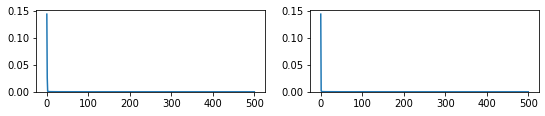

In [ ]:
epochs_counter=500
batch_size=64
train_losses, valid_losses = train(model,X_train_th,X_valid_th,Y_train_th,Y_valid_th,epochs=epochs_counter,batch_size=batch_size)

In [ ]:
model

Sequential(
  (0): Linear(in_features=64, out_features=128, bias=True)
  (1): LeakyReLU(negative_slope=0.01)
  (2): Linear(in_features=128, out_features=256, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=256, out_features=384, bias=True)
  (5): LeakyReLU(negative_slope=0.01)
  (6): Linear(in_features=384, out_features=256, bias=True)
  (7): LeakyReLU(negative_slope=0.01)
  (8): Linear(in_features=256, out_features=128, bias=True)
  (9): LeakyReLU(negative_slope=0.01)
  (10): Linear(in_features=128, out_features=64, bias=True)
  (11): Tanh()
)

In [ ]:
#TO SAVE THE MODEL

tosave_data = {'model': model,
               'epoch': epochs_counter,
               'batch_size': batch_size,
               'model_state_dict': model.state_dict(),
               'optimizer_state_dict': optimizer.state_dict(),
               'loss': loss_fn,
               'training loss': train_losses,
               'valid loss': valid_losses,}
               
# Write a pickle file using pytorch 

th.save(tosave_data, "modelff4")

## Model 5


In [ ]:
n_input=64
n_output=64
n_hidden=128
model = th.nn.Sequential(
    th.nn.Linear(n_input,n_hidden),
    th.nn.LeakyReLU(),
    th.nn.Linear(n_hidden,n_hidden*2),
    th.nn.LeakyReLU(),
    th.nn.Linear(n_hidden*2,n_hidden*3),
    th.nn.LeakyReLU(),
    th.nn.Linear(n_hidden*3,n_hidden*4),
    th.nn.LeakyReLU(),
    th.nn.Linear(n_hidden*4,n_hidden*3),
    th.nn.LeakyReLU(),
    th.nn.Linear(n_hidden*3,n_hidden*2),
    th.nn.LeakyReLU(),
    th.nn.Linear(n_hidden*2,n_hidden),
    th.nn.LeakyReLU(),
    th.nn.Linear(n_hidden,n_output),
    th.nn.Tanh()
)
model.double()
model.cuda()
optimizer=th.optim.Adam(model.parameters(),lr=1e-5)
loss_fn=th.nn.MSELoss()

Epoch	Train Loss	Valid Loss
0	 0.14369..	 0.14386..
1	 0.02866..	 0.00653..
2	 0.00243..	 0.00096..
3	 0.00074..	 0.00060..
4	 0.00052..	 0.00046..
5	 0.00042..	 0.00039..
6	 0.00036..	 0.00034..
7	 0.00032..	 0.00030..
8	 0.00029..	 0.00028..
9	 0.00027..	 0.00026..
10	 0.00025..	 0.00024..
11	 0.00023..	 0.00022..
12	 0.00022..	 0.00021..
13	 0.00020..	 0.00020..
14	 0.00019..	 0.00019..
15	 0.00018..	 0.00019..
16	 0.00017..	 0.00017..
17	 0.00016..	 0.00016..
18	 0.00016..	 0.00015..
19	 0.00015..	 0.00015..
20	 0.00014..	 0.00014..
21	 0.00014..	 0.00014..
22	 0.00013..	 0.00013..
23	 0.00012..	 0.00013..
24	 0.00012..	 0.00012..
25	 0.00012..	 0.00012..
26	 0.00011..	 0.00011..
27	 0.00011..	 0.00011..
28	 0.00010..	 0.00010..
29	 0.00010..	 0.00010..
30	 0.00010..	 0.00009..
31	 0.00009..	 0.00009..
32	 0.00009..	 0.00009..
33	 0.00009..	 0.00009..
34	 0.00008..	 0.00008..
35	 0.00008..	 0.00008..
36	 0.00008..	 0.00008..
37	 0.00008..	 0.00008..
38	 0.00007..	 0.00008..
39	 0.0

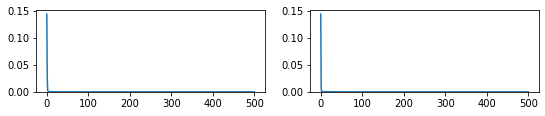

In [ ]:
epochs_counter=500
batch_size = 64
train_losses, valid_losses = train(model,X_train_th,X_valid_th,Y_train_th,Y_valid_th,epochs=epochs_counter,batch_size=batch_size)

In [ ]:
tosave_data = {'model': model,
               'epoch': epochs_counter,
               'batch_size': batch_size,
               'model_state_dict': model.state_dict(),
               'optimizer_state_dict': optimizer.state_dict(),
               'loss': loss_fn,  
               'training loss': train_losses,
               'valid loss': valid_losses,}
               
# Write a pickle file using pytorch 

th.save(tosave_data, "modelff5")

## Model 6

In [ ]:
n_input=64
n_output=64
n_hidden=128
model = th.nn.Sequential(
    th.nn.Linear(n_input,n_hidden),
    th.nn.LeakyReLU(),
    th.nn.Linear(n_hidden,n_hidden*2),
    th.nn.LeakyReLU(),
    th.nn.Linear(n_hidden*2,n_hidden*3),
    th.nn.LeakyReLU(),
    th.nn.Linear(n_hidden*3,n_hidden*4),
    th.nn.LeakyReLU(),
    th.nn.Linear(n_hidden*4,n_hidden*5),
    th.nn.LeakyReLU(),
    th.nn.Linear(n_hidden*5,n_hidden*4),
    th.nn.LeakyReLU(),
    th.nn.Linear(n_hidden*4,n_hidden*3),
    th.nn.LeakyReLU(),
    th.nn.Linear(n_hidden*3,n_hidden*2),
    th.nn.LeakyReLU(),
    th.nn.Linear(n_hidden*2,n_hidden),
    th.nn.LeakyReLU(),
    th.nn.Linear(n_hidden,n_output),
    th.nn.Tanh()
)
model.double()
model.cuda()
optimizer=th.optim.Adam(model.parameters(),lr=1e-5)
loss_fn=th.nn.MSELoss()

In [ ]:
epochs_counter=500
batch_size = 64
train_losses, valid_losses = train(model,X_train_th,X_valid_th,Y_train_th,Y_valid_th,epochs=epochs_counter,batch_size=batch_size)

Epoch	Train Loss	Valid Loss
0	 0.14337..	 0.14351..
1	 0.03155..	 0.01289..
2	 0.00932..	 0.00737..
3	 0.00564..	 0.00352..
4	 0.00205..	 0.00125..
5	 0.00098..	 0.00079..
6	 0.00069..	 0.00061..
7	 0.00054..	 0.00048..
8	 0.00044..	 0.00042..
9	 0.00038..	 0.00036..
10	 0.00033..	 0.00031..
11	 0.00030..	 0.00029..
12	 0.00028..	 0.00027..
13	 0.00026..	 0.00025..
14	 0.00024..	 0.00023..
15	 0.00023..	 0.00022..
16	 0.00021..	 0.00021..
17	 0.00020..	 0.00020..
18	 0.00019..	 0.00019..
19	 0.00018..	 0.00018..
20	 0.00017..	 0.00018..
21	 0.00017..	 0.00017..
22	 0.00016..	 0.00016..
23	 0.00015..	 0.00015..
24	 0.00014..	 0.00014..
25	 0.00014..	 0.00014..
26	 0.00013..	 0.00013..
27	 0.00013..	 0.00012..
28	 0.00012..	 0.00012..
29	 0.00012..	 0.00011..
30	 0.00011..	 0.00011..
31	 0.00011..	 0.00011..
32	 0.00010..	 0.00010..
33	 0.00010..	 0.00010..
34	 0.00010..	 0.00010..
35	 0.00009..	 0.00009..
36	 0.00009..	 0.00009..
37	 0.00009..	 0.00008..
38	 0.00008..	 0.00008..
39	 0.0

In [ ]:
tosave_data = {'model': model,
               'epoch': epochs_counter,
               'batch_size': batch_size,
               'model_state_dict': model.state_dict(),
               'optimizer_state_dict': optimizer.state_dict(),
               'loss': loss_fn,  
               'training loss': train_losses,
               'valid loss': valid_losses,}
               
# Write a pickle file using pytorch 

th.save(tosave_data, "modelff6")